In [ ]:
! pip install vaderSentiment pandas_datareader textblob

In [ ]:
pip install yfinance

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pandas_datareader as web
import datetime as dt
import yfinance as yf

import os
import re
import io
import nltk
import json

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from tqdm import tnrange, tqdm_notebook, tqdm
from sklearn import preprocessing
from time import sleep
from nltk.tokenize import TweetTokenizer
from nltk.stem.wordnet import WordNetLemmatizer
from textblob import TextBlob



crypto_currency = 'BTC'
against_currency = 'USD'
start = dt.datetime(2021, 2, 6)
end = dt.datetime.now()
data = yf.download(f'{crypto_currency}-{against_currency}', start=start, end=end)

tweets_raw_file   = '/content/input/Bitcoin_tweets.csv'
tweets_clean_file = './Bitcoin_tweets_clean.csv'

for dirname, _, filenames in os.walk('/content/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


[*********************100%%**********************]  1 of 1 completed
/content/input/Bitcoin_tweets.csv


In [ ]:
#df_raw = pd.read_csv(tweets_raw_file,low_memory=False)
df_raw = pd.read_csv(tweets_raw_file, low_memory=False, error_bad_lines=False)
print(df_raw.shape)
df_raw.head(5)

<ipython-input-24-06dade995c19>:2: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  df_raw = pd.read_csv(tweets_raw_file, low_memory=False, error_bad_lines=False)


(50993, 13)


,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,is_retweet
0,DeSota Wilson,"Atlanta, GA","Biz Consultant, real estate, fintech, startups...",2009-04-26 20:05:09,8534.0,7605,4838,False,2021-02-10 23:59:04,Blue Ridge Bank shares halted by NYSE after #b...,['bitcoin'],Twitter Web App,False
1,CryptoND,NaN,😎 BITCOINLIVE is a Dutch platform aimed at inf...,2019-10-17 20:12:10,6769.0,1532,25483,False,2021-02-10 23:58:48,"😎 Today, that's this #Thursday, we will do a ""...","['Thursday', 'Btc', 'wallet', 'security']",Twitter for Android,False
2,Tdlmatias,"London, England","IM Academy : The best #forex, #SelfEducation, ...",2014-11-10 10:50:37,128.0,332,924,False,2021-02-10 23:54:48,"Guys evening, I have read this article about B...",NaN,Twitter Web App,False
3,Crypto is the future,NaN,I will post a lot of buying signals for BTC tr...,2019-09-28 16:48:12,625.0,129,14,False,2021-02-10 23:54:33,$BTC A big chance in a billion! Price: \487264...,"['Bitcoin', 'FX', 'BTC', 'crypto']",dlvr.it,False
4,Alex Kirchmaier 🇦🇹🇸🇪 #FactsSuperspreader,Europa,Co-founder @RENJERJerky | Forbes 30Under30 | I...,2016-02-03 13:15:55,1249.0,1472,10482,False,2021-02-10 23:54:06,This network is secured by 9 508 nodes as of t...,['BTC'],Twitter Web App,False


In [ ]:
# clean df
df_raw = df_raw.sort_values(by = 'date')
dd = df_raw.sample(frac=0.01, replace=False, random_state=1)
dd.reset_index(inplace=True)
for i,s in enumerate(tqdm(dd['text'],position=0, leave=True)):
    text = str(dd.loc[i, 'text'])
    text = text.replace("#", "")
    text = re.sub('https?://(?:[-\w.]|(?:%[\da-fA-F]{2}))+', '', text, flags=re.MULTILINE)
    text = re.sub('@\\w+ *', '', text, flags=re.MULTILINE)
    dd.loc[i, 'text'] = text
# f = open(tweets_clean_file, 'a+', encoding='utf-8')
dd.to_csv(tweets_clean_file, header=True, encoding='utf-8',index=False)

100%|██████████| 510/510 [00:00<00:00, 6024.82it/s]


In [ ]:
df_clean = pd.read_csv(tweets_clean_file)

analyzer = SentimentIntensityAnalyzer()
compound = []
for i,s in enumerate(tqdm(df_clean['text'],position=0, leave=True)):
    # print(i,s)
    vs = analyzer.polarity_scores(str(s))
    compound.append(vs["compound"])
df_clean["compound"] = compound
df_clean.head(2)

100%|██████████| 510/510 [00:00<00:00, 4761.05it/s]


,index,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,is_retweet,compound
0,6619,DeSota Wilson,"Atlanta, GA","Biz Consultant, real estate, fintech, startups...",2009-04-26 20:05:09,8534.0,7605,4838,False,2021-02-09 06:27:04,"Bitcoin tops $47,000 for first time after purc...","['Bitcoin', 'BTC', 'crypto', 'cryptocurrency']",Twitter Web App,False,0.5106
1,12017,Mr. Whale📈🎈💕🎈,North Atlantic,Accounting/Finance guy🔸Crypto since 2017🔸I’m j...,2018-07-24 05:25:24,2264.0,92,7272,False,2021-02-08 13:00:12,i mean elon musk has been hinting this the pas...,"['bitcoin', 'btc']",Twitter Web App,False,-0.3699


In [ ]:
scores = []
for i, s in tqdm(df_clean.iterrows(), total=df_clean.shape[0],position=0, leave=True):
    try:
        scores.append(s["compound"] * ((int(s["user_followers"]))) * ((int(s["user_favourites"])+1)/int(s['user_followers']+1)) *((int(s["is_retweet"])+1)))
    except:
        scores.append(np.nan)
df_clean["score"] = scores
df_clean.head(2)

100%|██████████| 510/510 [00:00<00:00, 13875.45it/s]


,index,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,is_retweet,compound,score
0,6619,DeSota Wilson,"Atlanta, GA","Biz Consultant, real estate, fintech, startups...",2009-04-26 20:05:09,8534.0,7605,4838,False,2021-02-09 06:27:04,"Bitcoin tops $47,000 for first time after purc...","['Bitcoin', 'BTC', 'crypto', 'cryptocurrency']",Twitter Web App,False,0.5106,2470.503910
1,12017,Mr. Whale📈🎈💕🎈,North Atlantic,Accounting/Finance guy🔸Crypto since 2017🔸I’m j...,2018-07-24 05:25:24,2264.0,92,7272,False,2021-02-08 13:00:12,i mean elon musk has been hinting this the pas...,"['bitcoin', 'btc']",Twitter Web App,False,-0.3699,-2689.094937


In [ ]:
# sentiment analysis
df_clean = df_clean.drop_duplicates()
tweets = df_clean.copy()
tweets['date'] = pd.to_datetime(tweets['date'],utc=True)
tweets.date = tweets.date.dt.tz_localize(None)
tweets.index = tweets['date']

# tweets_grouped = tweets.groupby(pd.TimeGrouper('1h'))['score'].sum()
tweets_grouped = tweets.resample('1h').sum()

crypto_usd = data.copy()
# crypto_usd['Date'] = pd.to_datetime(crypto_usd['Date'], unit='s')
# crypto_usd.index = crypto_usd['Date']
# crypto_usd['Timestamp'] = pd.to_datetime(crypto_usd['Timestamp'], unit='s')
# crypto_usd.index = crypto_usd['Timestamp']

# crypto_usd_grouped = crypto_usd.groupby(pd.TimeGrouper('1h'))['Weighted_Price'].mean()
crypto_usd_grouped = crypto_usd.resample('D')['Close'].mean()

<ipython-input-28-b971c3127451>:9: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  tweets_grouped = tweets.resample('1h').sum()


In [ ]:
def crosscorr(datax, datay, lag=0, method="pearson"):
    """ Lag-N cross correlation.
    Parameters
    —------—
    lag : int, default 0
    datax, datay : pandas.Series objects of equal length

    Returns
    —------—
    crosscorr : float
    """
    return datax.corrwith(datay.shift(lag), method=method)['score']
# xcov = [crosscorr(tweets_grouped, crypto_usd_grouped, lag=i, m ='pearson' ) for i in range(-20,20)]
# tweets_grouped.corrwith(crypto_usd_grouped,method='pearson')

In [ ]:
beggining = max(tweets_grouped.index.min().replace(tzinfo=None), crypto_usd_grouped.index.min())
end = min(tweets_grouped.index.max().replace(tzinfo=None), crypto_usd_grouped.index.max())
tweets_grouped = tweets_grouped[beggining:end]
crypto_usd_grouped = crypto_usd_grouped[beggining:end]

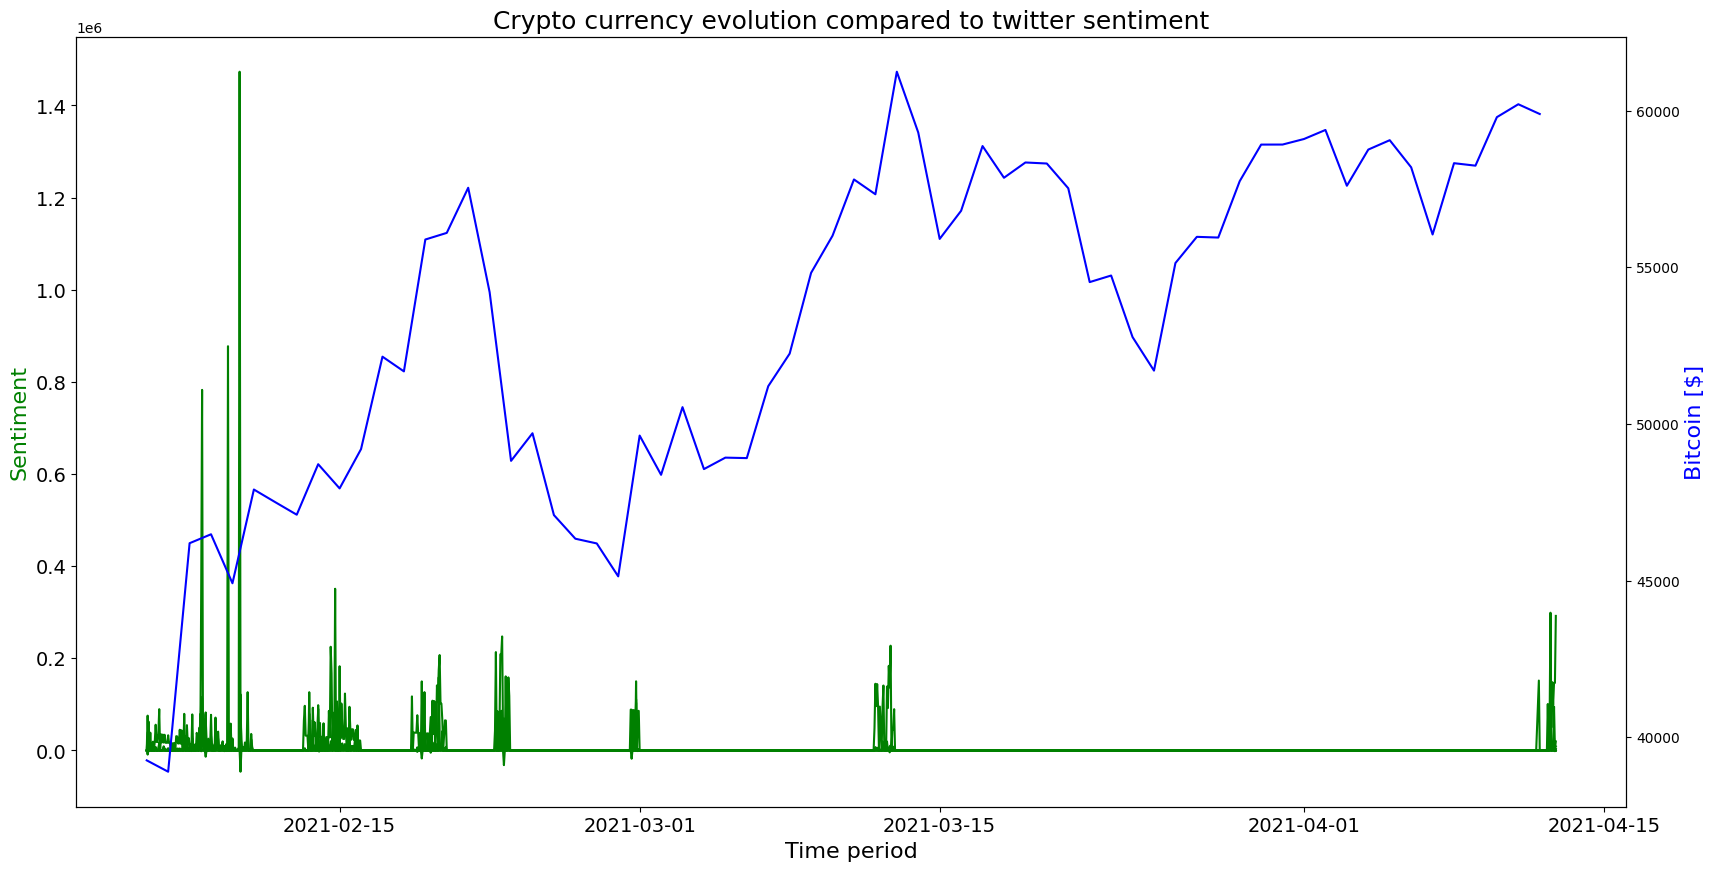

<Figure size 640x480 with 0 Axes>

In [ ]:
fig, ax1 = plt.subplots(figsize=(20,10))
ax1.set_title("Crypto currency evolution compared to twitter sentiment", fontsize=18)
ax1.tick_params(labelsize=14)
ax2 = ax1.twinx()
ax1.plot_date(tweets_grouped.index, tweets_grouped, 'g-')
ax2.plot_date(crypto_usd_grouped.index, crypto_usd_grouped, 'b-')

ax1.set_ylabel("Sentiment", color='g', fontsize=16)
ax1.set_xlabel("Time period", fontsize=16)
ax2.set_ylabel("Bitcoin [$]", color='b', fontsize=16)
plt.show()
plt.savefig('crypto_evolution_vs_twitter_sentiment', dpi=1000)


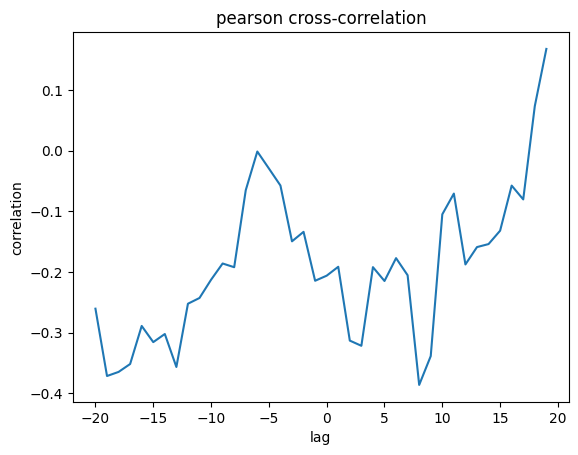

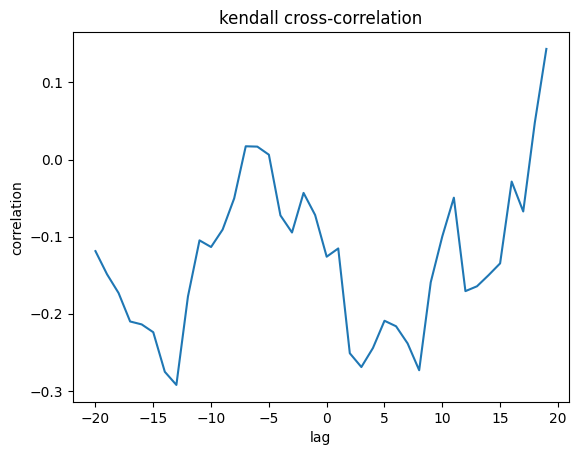

/usr/local/lib/python3.10/dist-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.10/dist-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.10/dist-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.10/dist-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.10/dist-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the

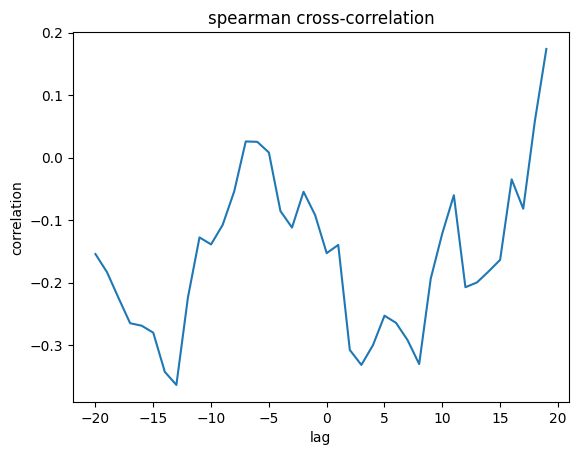

In [ ]:
xcov = [crosscorr(tweets_grouped, crypto_usd_grouped, lag=i, method="pearson") for i in range(-20,20)]
plt.plot(range(-20,20), xcov)
plt.title("pearson cross-correlation")
plt.xlabel("lag")
plt.ylabel("correlation")
plt.show()

xcov = [crosscorr(tweets_grouped, crypto_usd_grouped, lag=i, method="kendall") for i in range(-20,20)]
plt.plot(range(-20,20), xcov)
plt.title("kendall cross-correlation")
plt.xlabel("lag")
plt.ylabel("correlation")
plt.show()

xcov = [crosscorr(tweets_grouped, crypto_usd_grouped, lag=i, method="spearman") for i in range(-20,20)]
plt.plot(range(-20,20), xcov)
plt.title("spearman cross-correlation")
plt.xlabel("lag")
plt.ylabel("correlation")
plt.show()


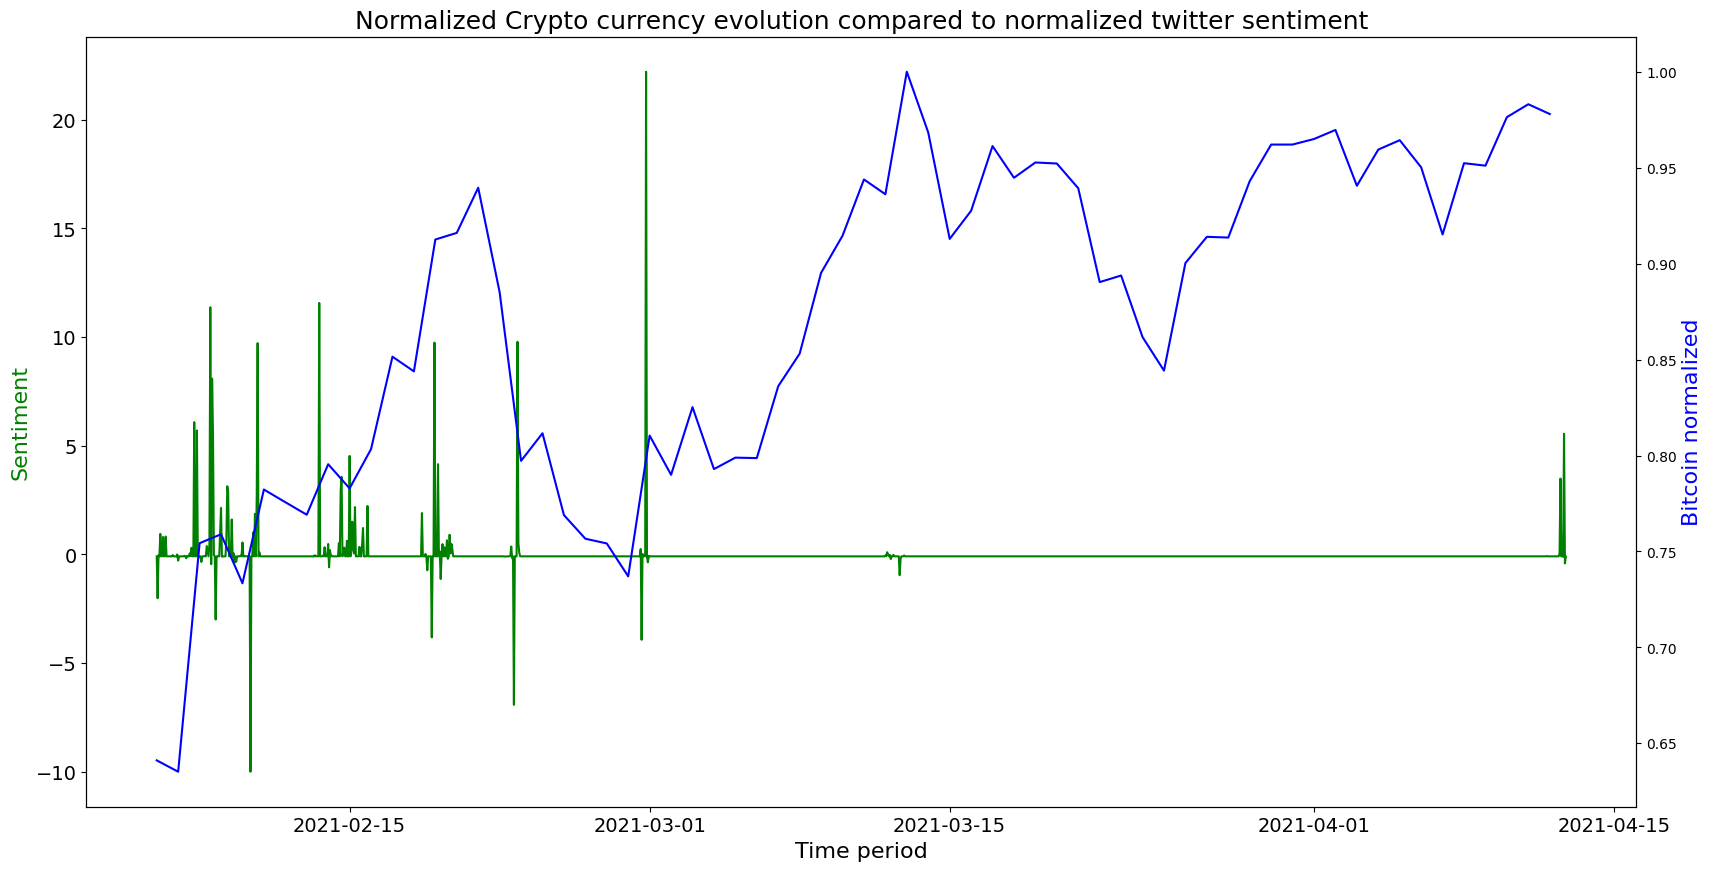

<Figure size 640x480 with 0 Axes>

In [ ]:
# Normalize time series data
min_max_scaler = preprocessing.StandardScaler()
score_scaled = min_max_scaler.fit_transform(tweets_grouped['score'].values.reshape(-1,1))
tweets_grouped['normalized_score'] = score_scaled
# crypto_used_grouped_scaled = min_max_scaler.fit_transform(crypto_usd_grouped.values.reshape(-1,1))
crypto_used_grouped_scaled = crypto_usd_grouped / max(crypto_usd_grouped.max(), abs(crypto_usd_grouped.min()))
# crypto_usd_grouped['normalized_price'] = crypto_used_grouped_scaled

fig, ax1 = plt.subplots(figsize=(20,10))
ax1.set_title("Normalized Crypto currency evolution compared to normalized twitter sentiment", fontsize=18)
ax1.tick_params(labelsize=14)

ax2 = ax1.twinx()
ax1.plot_date(tweets_grouped.index, tweets_grouped['normalized_score'], 'g-')
ax2.plot_date(crypto_usd_grouped.index, crypto_used_grouped_scaled, 'b-')

ax1.set_ylabel("Sentiment", color='g', fontsize=16)
ax1.set_xlabel("Time period", fontsize=16)
ax2.set_ylabel("Bitcoin normalized", color='b', fontsize=16)
plt.show()
plt.savefig('normalized_crypto_evolution_vs_twitter_sentiment', dpi=1000)

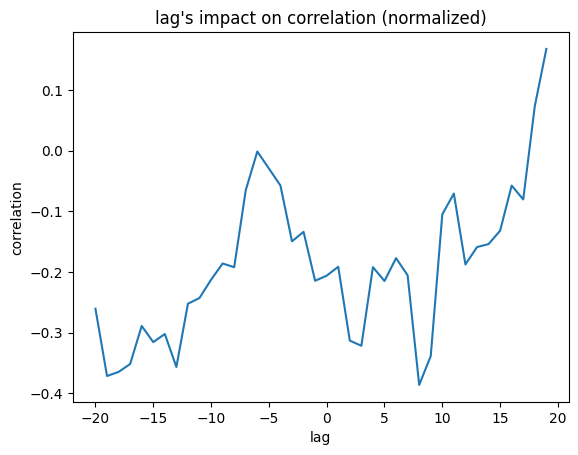

In [ ]:
#tweets_grouped.T.corr(crypto_usd_grouped, method='pearson')
#tweets_grouped.T.autocorr(crypto_usd_grouped, lag=20)
xcov = [crosscorr(tweets_grouped, crypto_usd_grouped, lag=i) for i in range(-20,20)]
plt.plot(range(-20,20), xcov)
plt.title("lag's impact on correlation (normalized)")
plt.xlabel("lag")
plt.ylabel("correlation")
plt.show()

In [ ]:
# Derivative
tweets_grouped_derivative = pd.Series(np.gradient(tweets_grouped['normalized_score'].values), tweets_grouped.index, name='slope')
crypto_usd_grouped_derivative = pd.Series(np.gradient(crypto_usd_grouped.values), crypto_usd_grouped.index, name='slope')

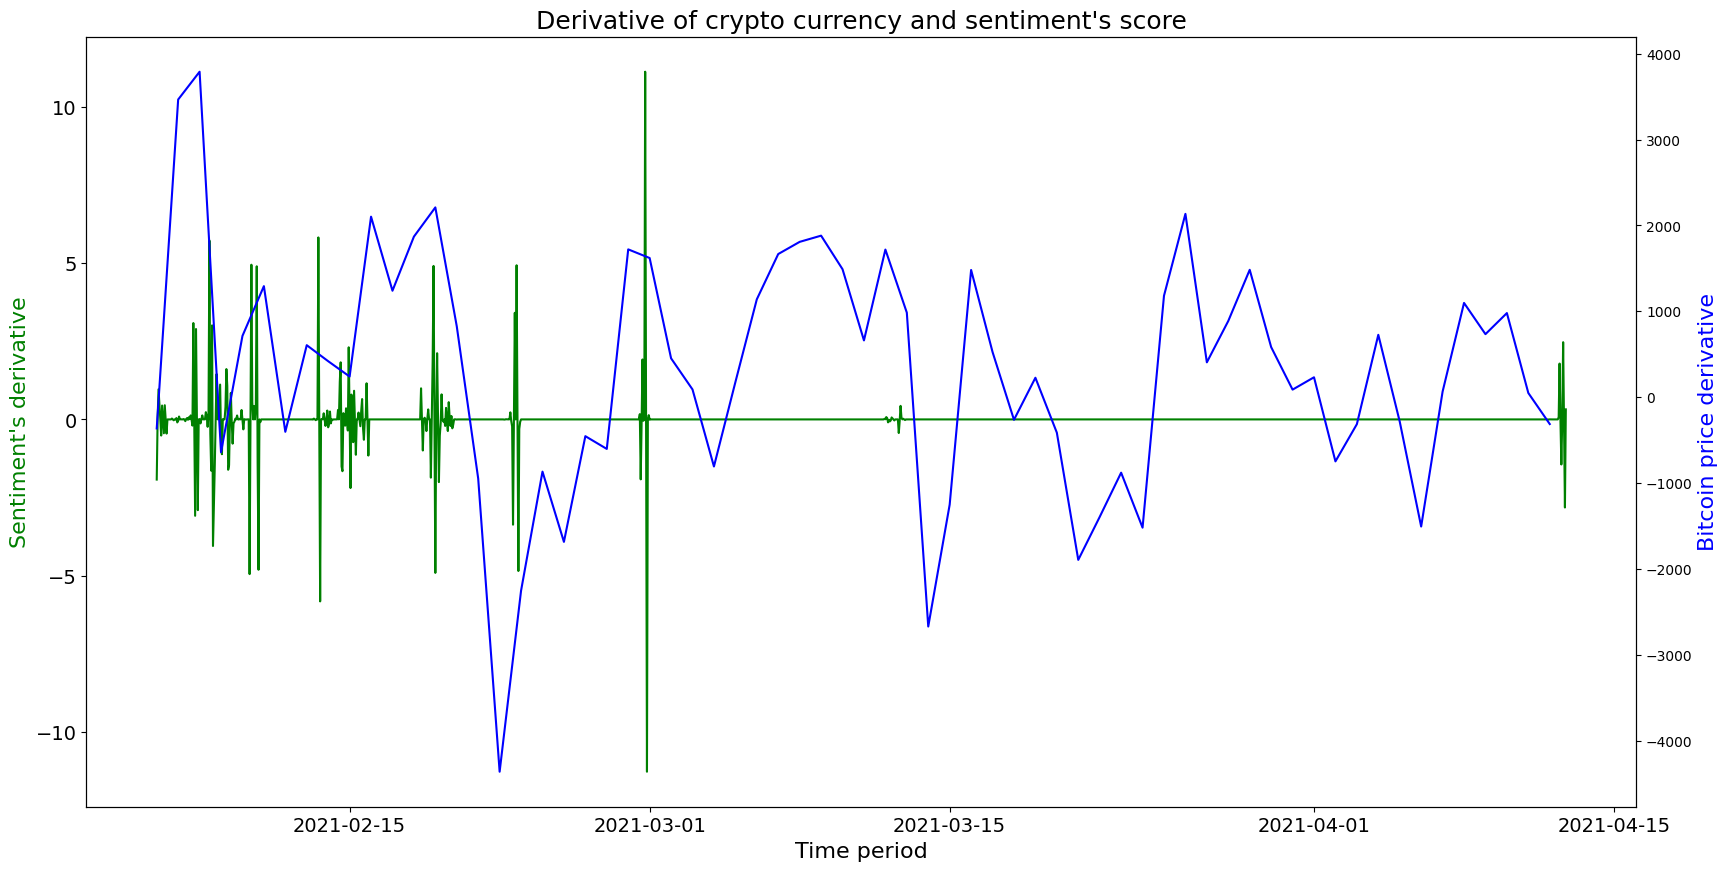

<Figure size 640x480 with 0 Axes>

In [ ]:
fig, ax1 = plt.subplots(figsize=(20,10))
ax1.set_title("Derivative of crypto currency and sentiment's score", fontsize=18)
ax1.set_xlabel("Time period", fontsize=16)
ax1.tick_params(labelsize=14)

ax2 = ax1.twinx()
ax1.plot_date(tweets_grouped_derivative.index, tweets_grouped_derivative, 'g-')
ax2.plot_date(crypto_usd_grouped_derivative.index, crypto_usd_grouped_derivative, 'b-')

ax1.set_ylabel("Sentiment's derivative", color='g', fontsize=16)
ax2.set_ylabel('Bitcoin price derivative', color='b', fontsize=16)
plt.show()
plt.savefig('derivative_crypto_currency_vs_twitter_sentiment', dpi=1000)

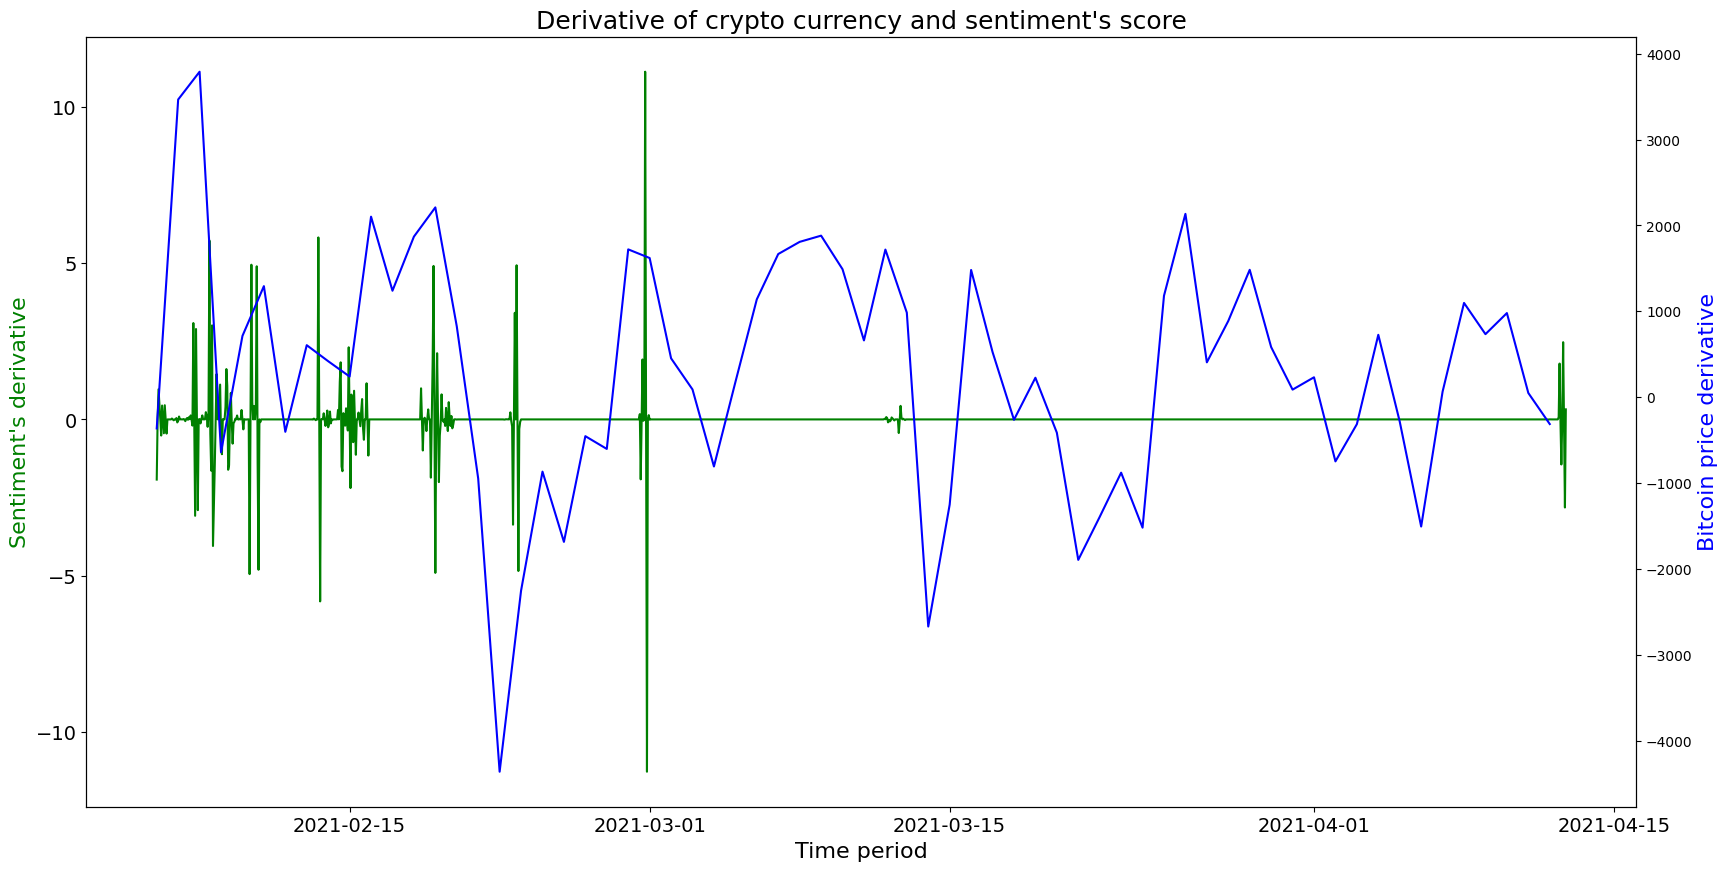

<Figure size 640x480 with 0 Axes>

In [ ]:
fig, ax1 = plt.subplots(figsize=(20,10))
ax1.set_title("Derivative of crypto currency and sentiment's score", fontsize=18)
ax1.set_xlabel("Time period", fontsize=16)
ax1.tick_params(labelsize=14)

ax2 = ax1.twinx()
ax1.plot_date(tweets_grouped_derivative.index, tweets_grouped_derivative, 'g-')
ax2.plot_date(crypto_usd_grouped_derivative.index, crypto_usd_grouped_derivative, 'b-')

ax1.set_ylabel("Sentiment's derivative", color='g', fontsize=16)
ax2.set_ylabel('Bitcoin price derivative', color='b', fontsize=16)
plt.show()
plt.savefig('derivative_crypto_currency_vs_twitter_sentiment', dpi=1000)

In [ ]:
df = df_clean.copy()
df.dropna(subset=['hashtags'], inplace=True)
df = df[['text']]
df.columns = ['tweets']
df.head()

,tweets
0,"Bitcoin tops $47,000 for first time after purc..."
1,i mean elon musk has been hinting this the pas...
2,"Bitcoin hits a record high of nearly $50,000 a..."
3,"New Tumblr post: ""crypto bitcoin cryptocurrenc..."
4,My 60 Years Old Father Got His First Crypto To...


In [ ]:
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt')
stop_words = nltk.corpus.stopwords.words(['english'])

print(stop_words)

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [ ]:
lem = WordNetLemmatizer()

def cleaning(data):
    #remove urls
    tweet_without_url = re.sub(r'http\S+',' ', data)

    #remove hashtags
    tweet_without_hashtag = re.sub(r'#\w+', ' ', tweet_without_url)

    #3. Remove mentions and characters that not in the English alphabets
    tweet_without_mentions = re.sub(r'@\w+',' ', tweet_without_hashtag)
    precleaned_tweet = re.sub('[^A-Za-z]+', ' ', tweet_without_mentions)

    #2. Tokenize
    tweet_tokens = TweetTokenizer().tokenize(precleaned_tweet)

    #3. Remove Puncs
    tokens_without_punc = [w for w in tweet_tokens if w.isalpha()]

    #4. Removing Stopwords
    tokens_without_sw = [t for t in tokens_without_punc if t not in stop_words]

    #5. lemma
    text_cleaned = [lem.lemmatize(t) for t in tokens_without_sw]

    #6. Joining
    return " ".join(text_cleaned)

In [ ]:
df['cleaned_tweets'] = df['tweets'].apply(cleaning)
df['date'] = df_clean['date']
df['date_clean'] = pd.to_datetime(df['date']).dt.strftime('%Y-%m-%d')
df.drop(columns='date',inplace=True)
df.head()

,tweets,cleaned_tweets,date_clean
0,"Bitcoin tops $47,000 for first time after purc...",Bitcoin top first time purchase xVOxO nFk BTC ...,2021-02-09
1,i mean elon musk has been hinting this the pas...,mean elon musk hinting past week surprised LFG...,2021-02-08
2,"Bitcoin hits a record high of nearly $50,000 a...",Bitcoin hit record high nearly major firm floc...,2021-02-15
3,"New Tumblr post: ""crypto bitcoin cryptocurrenc...",New Tumblr post crypto bitcoin cryptocurrency ...,2021-02-06
4,My 60 Years Old Father Got His First Crypto To...,My Years Old Father Got His First Crypto Today...,2021-02-19


In [ ]:
def getSubjectivity(tweet):
    return TextBlob(tweet).sentiment.subjectivity

def getPolarity(tweet):
    return TextBlob(tweet).sentiment.polarity

In [ ]:
def crypto_price_cate(score):
    if score < 1:
        return 'negative'
    elif score == 1:
        return 'neutral'
    else:
        return 'positive'
def observe_period(period):
    res = crypto_usd_grouped.shift(period)/crypto_usd_grouped
    res = res.apply(crypto_price_cate)
    return res

time_sentiment = observe_period(7) # compare price ratio in 7 days. price_7_days_later/ price_now
df['crypto_sentiment'] = df.date_clean.apply(lambda x: time_sentiment[x] if x in time_sentiment else np.nan)

In [ ]:
# may takes time
df['subjectivity'] = df['cleaned_tweets'].apply(getSubjectivity)
df['polarity'] = df['cleaned_tweets'].apply(getPolarity)
df.head()

,tweets,cleaned_tweets,date_clean,crypto_sentiment,subjectivity,polarity
0,"Bitcoin tops $47,000 for first time after purc...",Bitcoin top first time purchase xVOxO nFk BTC ...,2021-02-09,positive,0.416667,0.375000
1,i mean elon musk has been hinting this the pas...,mean elon musk hinting past week surprised LFG...,2021-02-08,positive,0.612500,-0.154167
2,"Bitcoin hits a record high of nearly $50,000 a...",Bitcoin hit record high nearly major firm floc...,2021-02-15,negative,0.480000,0.007500
3,"New Tumblr post: ""crypto bitcoin cryptocurrenc...",New Tumblr post crypto bitcoin cryptocurrency ...,2021-02-06,positive,0.454545,0.136364
4,My 60 Years Old Father Got His First Crypto To...,My Years Old Father Got His First Crypto Today...,2021-02-19,negative,0.266667,0.175000


In [ ]:
def getSentiment(score):
    if score < 0:
        return 'negative'
    elif score == 0:
        return 'neutral'
    else:
        return 'positive'
df['sentiment'] = df['polarity'].apply(getSentiment)
df['target'] = df['sentiment'] == df['crypto_sentiment']
df.head()
df.to_csv('./df_data.csv')

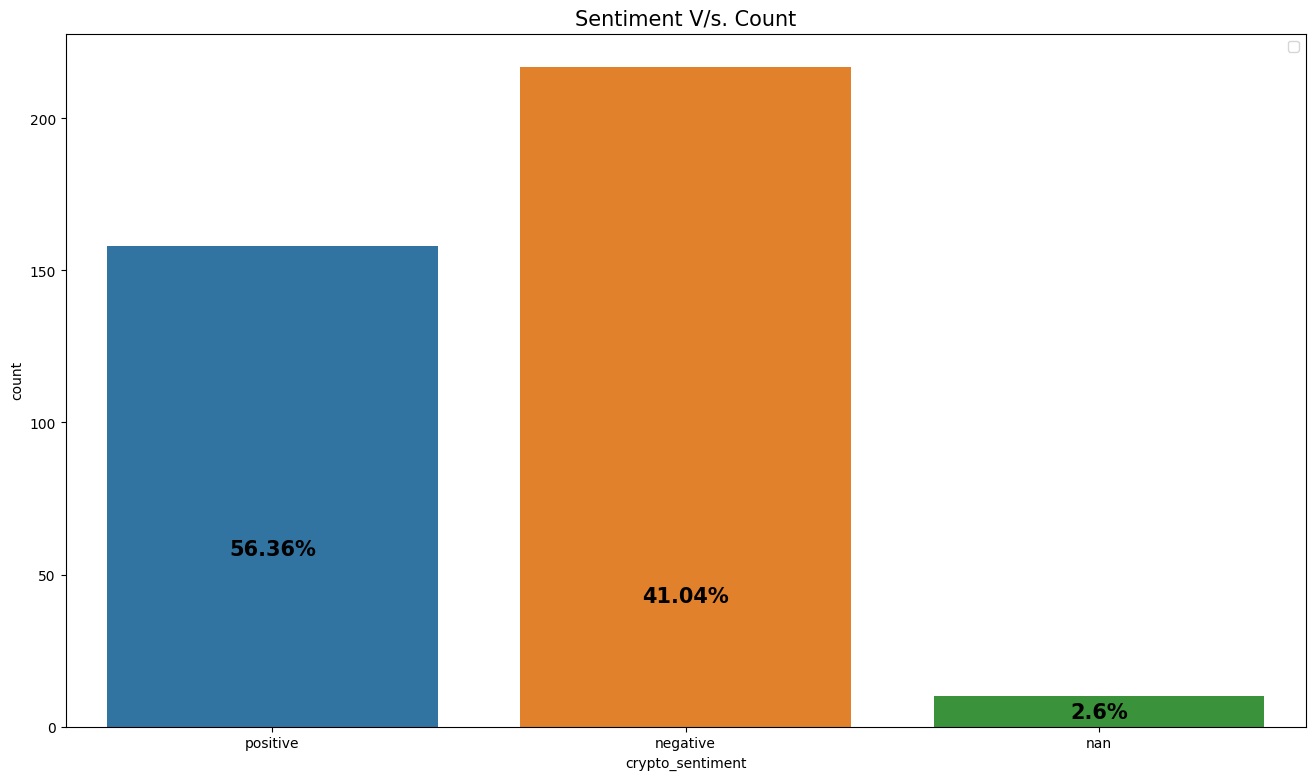

<Figure size 640x480 with 0 Axes>

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

plt.figure(figsize=[16, 9])

# Assuming df is defined and has the 'crypto_sentiment' column
df['crypto_sentiment'] = df['crypto_sentiment'].astype(str)
df = df.dropna(subset=['crypto_sentiment'])

# Plot the countplot
sns.countplot(data=df, x='crypto_sentiment')
plt.title('Sentiment V/s. Count', fontsize=15)

# Annotate the bar plot with percentages
label = (df['crypto_sentiment'].value_counts(normalize=True) * 100).round(2)
for i in range(len(label)):
    plt.text(x=i, y=label[i], s=f"{label[i]}%", horizontalalignment='center', rotation=360, color="black",
             weight="bold", fontsize=15)

# Show legend
plt.legend()

# Show the plot
plt.show()

# Save the figure after showing it
plt.savefig('sentiment_vs_count.png', dpi=1000)


In [ ]:
import tensorflow as tf
import tensorflow.keras.layers as Layers
import tensorflow.keras.backend as K
import seaborn as sns

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Dropout, Embedding, LSTM, Conv1D, GlobalMaxPooling1D, Bidirectional, SpatialDropout1D
from tensorflow.keras.models import load_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Embedding,Conv1D,MaxPooling1D,LSTM
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report
from sklearn.metrics import confusion_matrix
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, Bidirectional, LSTM, Dense, Dropout
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras import datasets
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.callbacks import History
from tensorflow.keras import losses


In [ ]:
import pandas as pd

# Assuming you have a CSV file named 'your_data.csv'
df = pd.read_csv('df_data.csv')

# Now you can display the first few rows of the DataFrame
df.head()


,Unnamed: 0,tweets,cleaned_tweets,date_clean,crypto_sentiment,subjectivity,polarity,sentiment,target
0,0,"Bitcoin tops $47,000 for first time after purc...",Bitcoin top first time purchase xVOxO nFk BTC ...,2021-02-09,positive,0.416667,0.375000,positive,True
1,1,i mean elon musk has been hinting this the pas...,mean elon musk hinting past week surprised LFG...,2021-02-08,positive,0.612500,-0.154167,negative,False
2,2,"Bitcoin hits a record high of nearly $50,000 a...",Bitcoin hit record high nearly major firm floc...,2021-02-15,negative,0.480000,0.007500,positive,False
3,3,"New Tumblr post: ""crypto bitcoin cryptocurrenc...",New Tumblr post crypto bitcoin cryptocurrency ...,2021-02-06,positive,0.454545,0.136364,positive,True
4,4,My 60 Years Old Father Got His First Crypto To...,My Years Old Father Got His First Crypto Today...,2021-02-19,negative,0.266667,0.175000,positive,False


In [ ]:
X = df['cleaned_tweets']
y = pd.get_dummies(df['sentiment']).values
num_classes = df['sentiment'].nunique()

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split

# Example data (replace this with your actual data)
#X = np.random.rand(100, 5)  # 100 samples, 5 features
#y = np.random.randint(0, 2, 100)  # Binary labels (0 or 1)

seed = 38  # Fix random seed for reproducibility
np.random.seed(seed)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    stratify=y,
                                                    random_state=seed)

# Print the shapes of the resulting sets
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)


(308,) (77,) (308, 3) (77, 3)


In [ ]:
max_features = 20000
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(X_train))
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [ ]:
from tensorflow.keras.preprocessing import sequence
max_words = 30
X_train = sequence.pad_sequences(X_train, maxlen=max_words)
X_test = sequence.pad_sequences(X_test, maxlen=max_words)
print(X_train.shape,X_test.shape)


(308, 30) (77, 30)


In [ ]:
import tensorflow.keras.backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Embedding,Conv1D,MaxPooling1D,LSTM
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report

batch_size = 128
epochs = 10

max_features = 20000
embed_dim = 100

np.random.seed(seed)
K.clear_session()
model = Sequential()
model.add(Embedding(max_features, embed_dim, input_length=X_train.shape[1]))
model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(num_classes, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 30, 100)           2000000   
                                                                 
 conv1d (Conv1D)             (None, 30, 32)            9632      
                                                                 
 max_pooling1d (MaxPooling1  (None, 15, 32)            0         
 D)                                                              
                                                                 
 conv1d_1 (Conv1D)           (None, 15, 32)            3104      
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 7, 32)             0         
 g1D)                                                            
                                                                 
 lstm (LSTM)                 (None, 100)               5

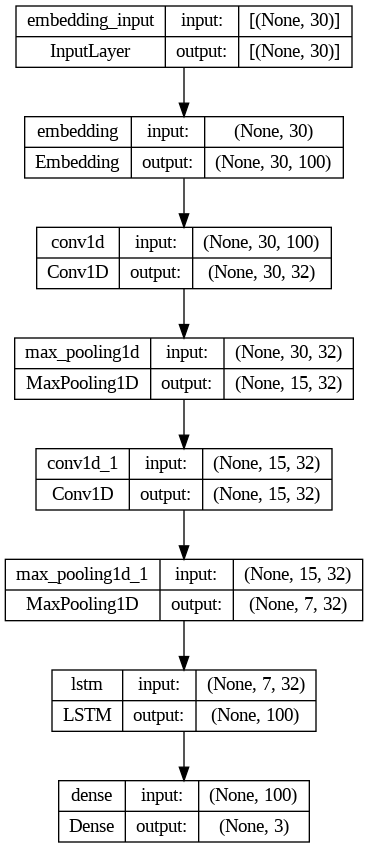

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [ ]:
history = model.fit(X_train, y_train, validation_data=(X_test, y_test),
                          epochs=epochs, batch_size=batch_size, verbose=2)

Epoch 1/10
3/3 - 7s - loss: 1.0984 - accuracy: 0.3377 - val_loss: 1.0832 - val_accuracy: 0.5714 - 7s/epoch - 2s/step
Epoch 2/10
3/3 - 0s - loss: 1.0748 - accuracy: 0.6039 - val_loss: 1.0589 - val_accuracy: 0.5584 - 209ms/epoch - 70ms/step
Epoch 3/10
3/3 - 0s - loss: 1.0455 - accuracy: 0.5649 - val_loss: 1.0192 - val_accuracy: 0.5584 - 208ms/epoch - 69ms/step
Epoch 4/10
3/3 - 0s - loss: 0.9979 - accuracy: 0.5649 - val_loss: 0.9588 - val_accuracy: 0.5584 - 212ms/epoch - 71ms/step
Epoch 5/10
3/3 - 0s - loss: 0.9277 - accuracy: 0.5649 - val_loss: 0.9071 - val_accuracy: 0.5584 - 215ms/epoch - 72ms/step
Epoch 6/10
3/3 - 0s - loss: 0.8909 - accuracy: 0.5649 - val_loss: 0.9478 - val_accuracy: 0.5584 - 352ms/epoch - 117ms/step
Epoch 7/10
3/3 - 0s - loss: 0.8930 - accuracy: 0.5649 - val_loss: 0.9222 - val_accuracy: 0.5584 - 447ms/epoch - 149ms/step
Epoch 8/10
3/3 - 0s - loss: 0.8614 - accuracy: 0.5649 - val_loss: 0.9006 - val_accuracy: 0.5584 - 287ms/epoch - 96ms/step
Epoch 9/10
3/3 - 0s - loss:

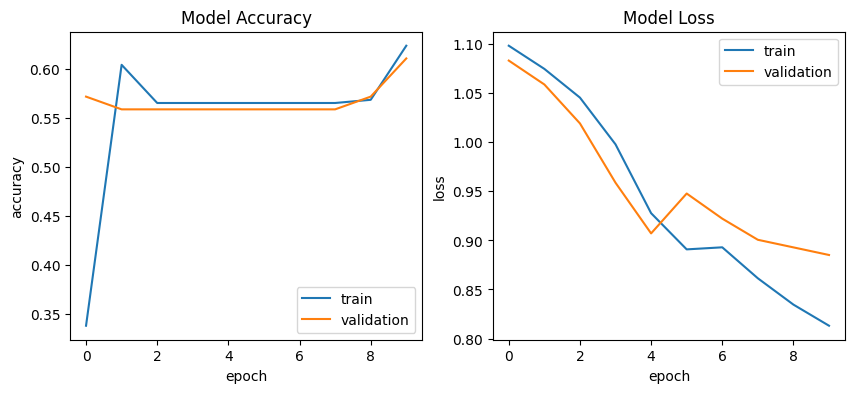

In [ ]:
def plot_training_hist(history):
    '''Function to plot history for accuracy and loss'''

    fig, ax = plt.subplots(1,2, figsize=(10,4))
    # first plot
    ax[0].plot(history.history['accuracy'])
    ax[0].plot(history.history['val_accuracy'])
    ax[0].set_title('Model Accuracy')
    ax[0].set_xlabel('epoch')
    ax[0].set_ylabel('accuracy')
    ax[0].legend(['train', 'validation'], loc='best')

    # second plot
    ax[1].plot(history.history['loss'])
    ax[1].plot(history.history['val_loss'])
    ax[1].set_title('Model Loss')
    ax[1].set_xlabel('epoch')
    ax[1].set_ylabel('loss')
    ax[1].legend(['train', 'validation'], loc='best')

    plt.savefig("train_accuracy_loss", dpi=1000)

plot_training_hist(history)


In [ ]:
# predict class with test set
y_pred_test =  np.argmax(model.predict(X_test), axis=1)
print('Accuracy:\t{:0.1f}%'.format(accuracy_score(np.argmax(y_test,axis=1),y_pred_test)*100))
print(classification_report(np.argmax(y_test,axis=1), y_pred_test))

3/3 [==============================] - 1s 13ms/step
Accuracy:	61.0%
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         7
           1       0.59      1.00      0.74        43
           2       1.00      0.15      0.26        27

    accuracy                           0.61        77
   macro avg       0.53      0.38      0.33        77
weighted avg       0.68      0.61      0.50        77



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


3/3 [==============================] - 0s 9ms/step
1    43
2    27
0     7
dtype: int64
1    73
2     4
dtype: int64


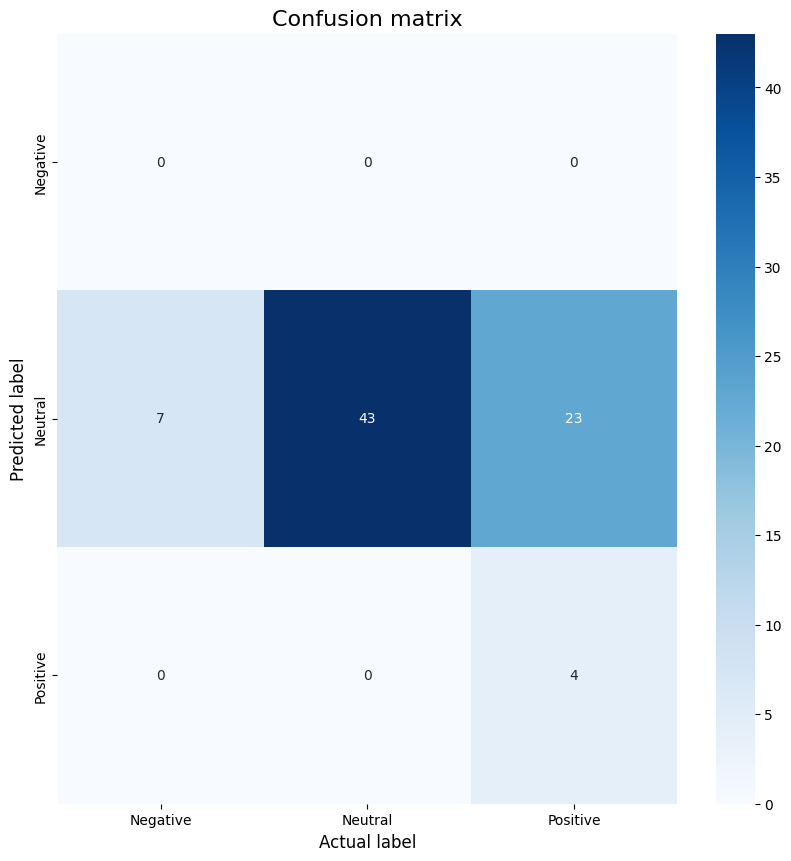

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
def plot_confusion_matrix(model, X_test, y_test):
    '''Function to plot confusion matrix for the passed model and the data'''

    sentiment_classes = ['Negative','Neutral', 'Positive']
    # use model to do the prediction
    y_pred = model.predict(X_test)
    # compute confusion matrix
    cm = confusion_matrix(np.argmax(y_pred, axis=1),np.argmax(np.array(y_test),axis=1))

    print(pd.Series(np.argmax(np.array(y_test),axis=1)).value_counts())
    print(pd.Series(np.argmax(y_pred, axis=1)).value_counts())

    # plot confusion matrix
    plt.figure(figsize=(10,10))
    sns.heatmap(cm, cmap=plt.cm.Blues, annot=True, fmt='d',
                xticklabels=sentiment_classes,
                yticklabels=sentiment_classes)
    plt.title('Confusion matrix', fontsize=16)
    plt.xlabel('Actual label', fontsize=12)
    plt.ylabel('Predicted label', fontsize=12)
    plt.savefig("train_matrix", dpi=1000)

plot_confusion_matrix(model, X_test, y_test)

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

max_words = 5000
max_len=50

def tokenize_pad_sequences(text):
    '''
    This function tokenize the input text into sequnences of intergers and then
    pad each sequence to the same length
    '''
    # Text tokenization
    tokenizer = Tokenizer(num_words=max_words, lower=True, split=' ')
    tokenizer.fit_on_texts(text)
    # Transforms text to a sequence of integers
    X = tokenizer.texts_to_sequences(text)
    # Pad sequences to the same length
    X = pad_sequences(X, padding='post', maxlen=max_len)
    # return sequences
    return X, tokenizer

print('Before Tokenization & Padding \n', df['cleaned_tweets'][0])
X, tokenizer = tokenize_pad_sequences(df['cleaned_tweets'])
print('After Tokenization & Padding \n', X[0])

Before Tokenization & Padding 
 Bitcoin top first time purchase xVOxO nFk BTC BTC crypto cryptocurrency TSLA
After Tokenization & Padding 
 [  1 127 211  27 212 521 522   2   2   3   4 159   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0]


In [ ]:
y = pd.get_dummies(df['sentiment'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1)
print('Train Set: ', X_train.shape, y_train.shape)
print('Validation Set: ', X_val.shape, y_val.shape)
print('Test Set: ', X_test.shape, y_test.shape)

Train Set:  (231, 50) (231, 3)
Validation Set:  (77, 50) (77, 3)
Test Set:  (77, 50) (77, 3)


In [ ]:
import tensorflow.keras.backend as K

def f1_score(precision, recall):
    ''' Function to calculate f1 score '''

    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, Bidirectional, LSTM, Dense, Dropout
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras import datasets
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.callbacks import History
from tensorflow.keras import losses

In [ ]:
vocab_size = 5000
embedding_size = 32
epochs = 50
learning_rate = 0.01
decay_rate = learning_rate / epochs
momentum = 0.8

In [ ]:
from tensorflow.keras.optimizers import SGD
sgd = SGD(learning_rate=learning_rate, momentum=momentum, nesterov=False)
model= Sequential()
model.add(Embedding(vocab_size, embedding_size, input_length=max_len))
model.add(Conv1D(filters=32, kernel_size=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Bidirectional(LSTM(32)))
model.add(Dropout(0.4))
model.add(Dense(3, activation='softmax'))

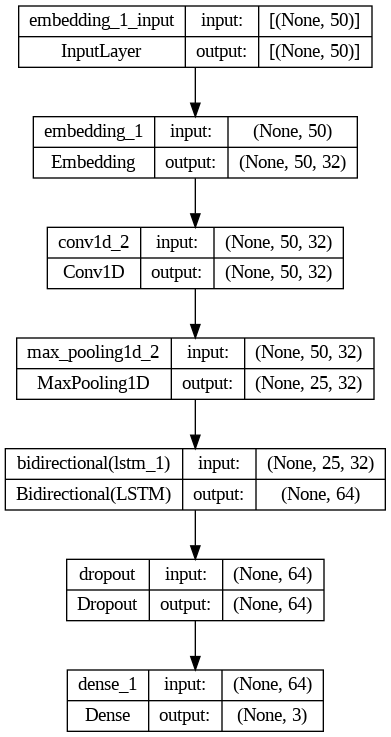

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy', Precision(), Recall()])

In [ ]:
history = model.fit(X_train,y_train,validation_data=(X_val, y_val),batch_size=batch_size,epochs=epochs,verbose=1)

Epoch 1/50
2/2 [==============================] - 7s 1s/step - loss: 1.0962 - accuracy: 0.4026 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 1.0876 - val_accuracy: 0.3636 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/50
2/2 [==============================] - 0s 81ms/step - loss: 1.0851 - accuracy: 0.3896 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 1.0670 - val_accuracy: 0.5714 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/50
2/2 [==============================] - 0s 73ms/step - loss: 1.0600 - accuracy: 0.5281 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 1.0443 - val_accuracy: 0.5714 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/50
2/2 [==============================] - 0s 91ms/step - loss: 1.0367 - accuracy: 0.5628 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 1.0223 - val_accuracy: 0.5714 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 5/50
2/2 [==============================] - 0s 6

In [ ]:
# Evaluate model on the test set
loss, accuracy, precision, recall = model.evaluate(X_test, y_test, verbose=0)
# Print metrics
print('')
print('Accuracy  : {:.4f}'.format(accuracy))
print('Precision : {:.4f}'.format(precision))
print('Recall    : {:.4f}'.format(recall))
print('F1 Score  : {:.4f}'.format(f1_score(precision, recall)))


Accuracy  : 0.5065
Precision : 0.5065
Recall    : 0.5065
F1 Score  : 0.5065


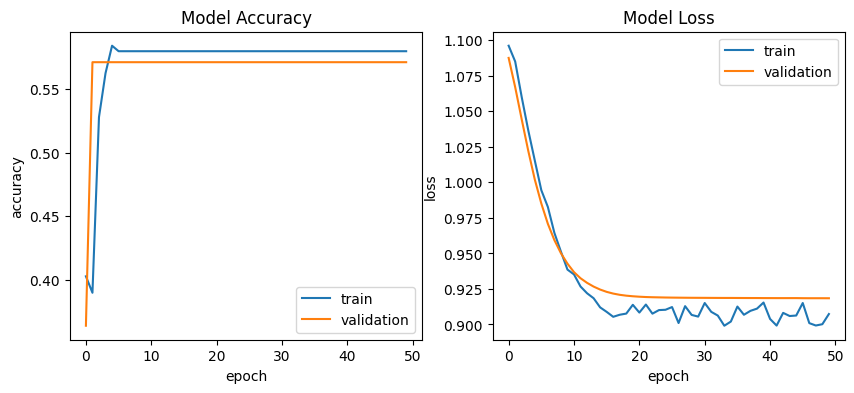

In [ ]:
plot_training_hist(history)

3/3 [==============================] - 1s 9ms/step
1    39
2    33
0     5
dtype: int64
1    77
dtype: int64


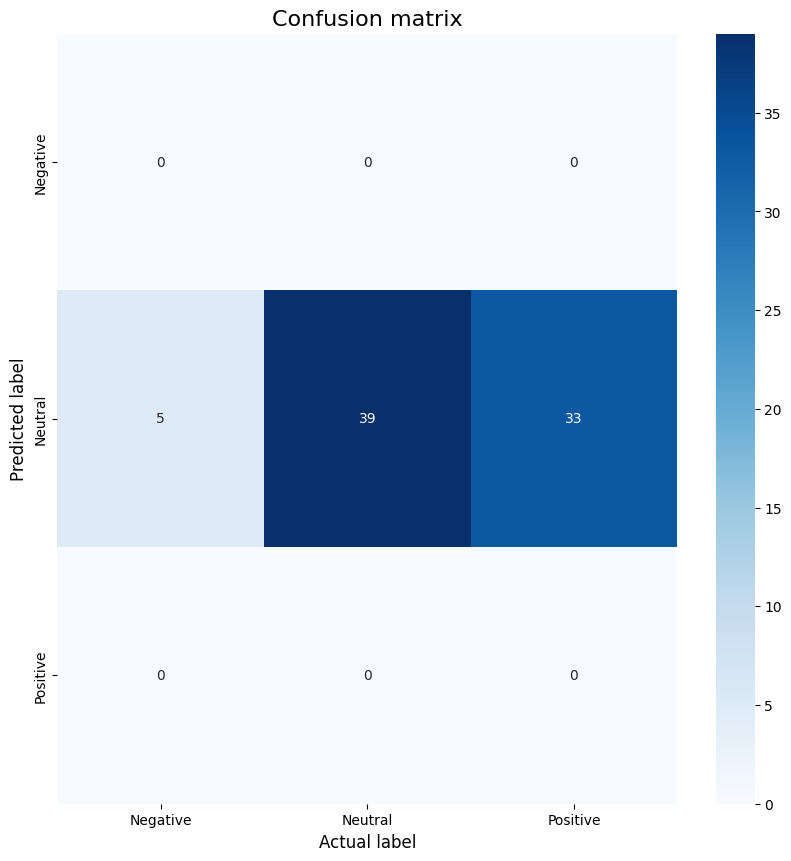

In [ ]:
plot_confusion_matrix(model, X_test, y_test)

In [ ]:
! pip install pandas_datareader

In [ ]:
pip install yfinance


In [ ]:
import yfinance as yf
import datetime as dt

# Set the parameters
crypto_currency = 'BTC'
against_currency = 'USD'
start = dt.datetime(2016, 1, 1)
end = dt.datetime.now()

# Fetch historical cryptocurrency data using yfinance
data = yf.download(f'{crypto_currency}-{against_currency}', start=start, end=end)

# Display the data
print(data.head())


[*********************100%%**********************]  1 of 1 completed
                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2016-01-01  430.721008  436.246002  427.515015  434.334015  434.334015   
2016-01-02  434.622009  436.062012  431.869995  433.437988  433.437988   
2016-01-03  433.578003  433.743011  424.705994  430.010986  430.010986   
2016-01-04  430.061005  434.516998  429.084015  433.091003  433.091003   
2016-01-05  433.069000  434.182007  429.675995  431.959991  431.959991   

              Volume  
Date                  
2016-01-01  36278900  
2016-01-02  30096600  
2016-01-03  39633800  
2016-01-04  38477500  
2016-01-05  34522600  


In [ ]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data['Close'].values.reshape(-1, 1))

preddays = 10

x_train, y_train = [], []
for x in range(preddays, len(scaled_data)):
    x_train.append(scaled_data[x-preddays:x, 0])
    y_train.append(scaled_data[x, 0])

x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

In [ ]:
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units = 1))

model.compile(optimizer='adam', loss='mean_squared_error')
history = model.fit(x_train, y_train, epochs=50, batch_size=32, verbose=1)
## Add validation data here

Epoch 1/50
91/91 [==============================] - 14s 22ms/step - loss: 0.0125
Epoch 2/50
91/91 [==============================] - 2s 20ms/step - loss: 0.0023
Epoch 3/50
91/91 [==============================] - 2s 19ms/step - loss: 0.0022
Epoch 4/50
91/91 [==============================] - 2s 20ms/step - loss: 0.0019
Epoch 5/50
91/91 [==============================] - 2s 19ms/step - loss: 0.0017
Epoch 6/50
91/91 [==============================] - 2s 21ms/step - loss: 0.0016
Epoch 7/50
91/91 [==============================] - 3s 31ms/step - loss: 0.0017
Epoch 8/50
91/91 [==============================] - 2s 25ms/step - loss: 0.0017
Epoch 9/50
91/91 [==============================] - 2s 19ms/step - loss: 0.0016
Epoch 10/50
91/91 [==============================] - 2s 19ms/step - loss: 0.0016
Epoch 11/50
91/91 [==============================] - 2s 19ms/step - loss: 0.0015
Epoch 12/50
91/91 [==============================] - 2s 19ms/step - loss: 0.0018
Epoch 13/50
91/91 [=================

In [ ]:
test_start = dt.datetime(2021, 6, 1)
test_end = dt.datetime.now()
test_data = data.loc[(data.index >= test_start) & (data.index <= test_end)]
actual_prices = test_data['Close'].values

total_dataset = pd.concat((data['Close'], test_data['Close']), axis=0)

In [ ]:
model_inputs = total_dataset[len(total_dataset) - len(test_data) - preddays:].values
model_inputs = model_inputs.reshape(-1, 1)
model_inputs = scaler.fit_transform(model_inputs)

x_test = []

for x in range(preddays,  len(model_inputs)):
    x_test.append(model_inputs[x-preddays:x, 0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

29/29 [==============================] - 4s 13ms/step


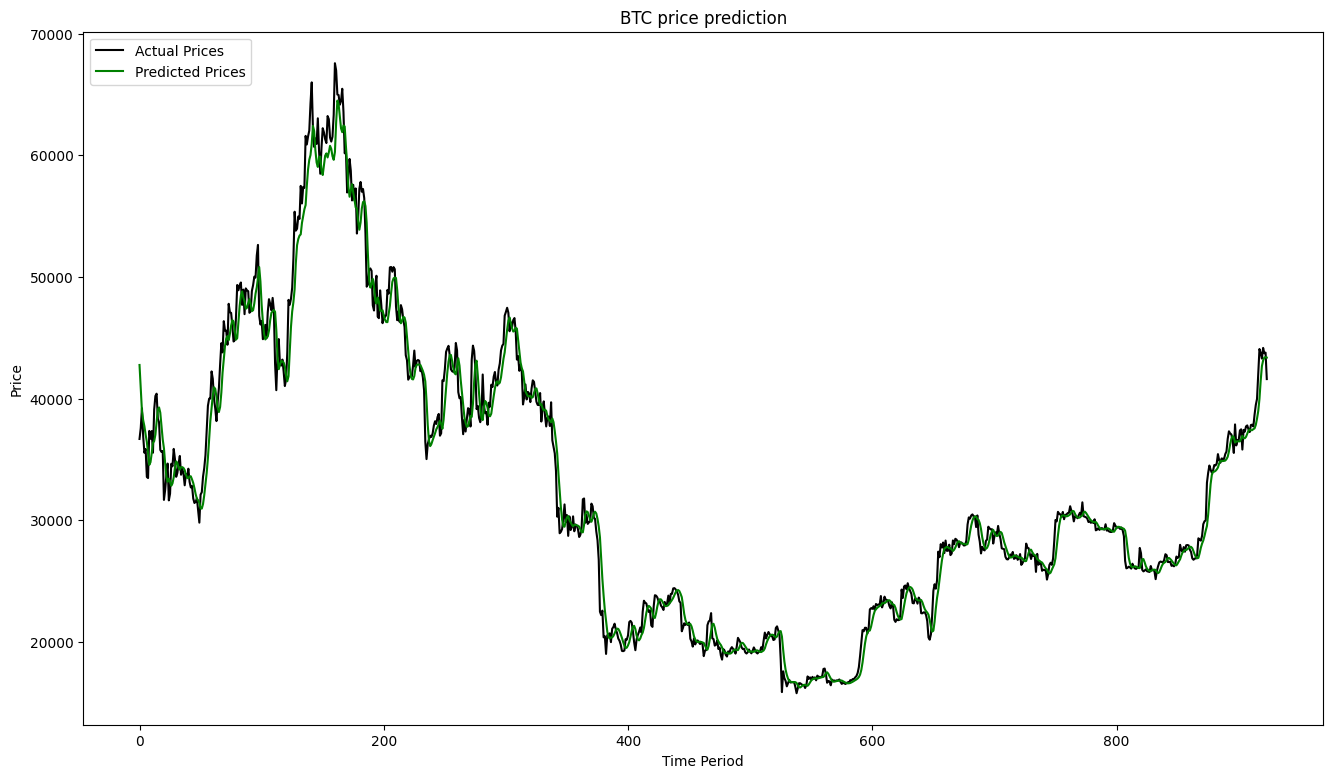

<Figure size 640x480 with 0 Axes>

In [ ]:
pred = model.predict(x_test)
pred = scaler.inverse_transform(pred)

plt.figure(figsize=(16,9))
plt.plot(actual_prices, color='black', label='Actual Prices')
plt.plot(pred, color='green', label='Predicted Prices')
plt.title(f'BTC price prediction')
plt.xlabel('Time Period')
plt.ylabel('Price')
plt.legend(loc='upper left')
plt.show()
plt.savefig("btc_price_prediction", dpi=1000)

In [ ]:
print("The Predicted price of Bitcoin for today is $" + str(float(pred[-1])))
print("The last hour's close price of Bitcoin is $" + str(float(data.tail(1)['Close'])))

The Predicted price of Bitcoin for today is $43373.31640625
The last hour's close price of Bitcoin is $41606.31640625
